# Code

In [1]:
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
# from ipyparallel import Client
# from tqdm import tqdm

In [2]:
sns.set_style('whitegrid')

## Model implementation

In [3]:
# AD parameters
m = 10
eps = 0.01
gamma = 2.1
gamma_2 = 1 - gamma

In [4]:
def F(a):
    return (a**(gamma_2) - eps**(gamma_2)) / (1 - eps**(gamma_2))

def generate_activities(N):
    U = np.random.rand(N)
    return (eps**gamma_2 + U * (1 - eps**gamma_2))**(1 / gamma_2)

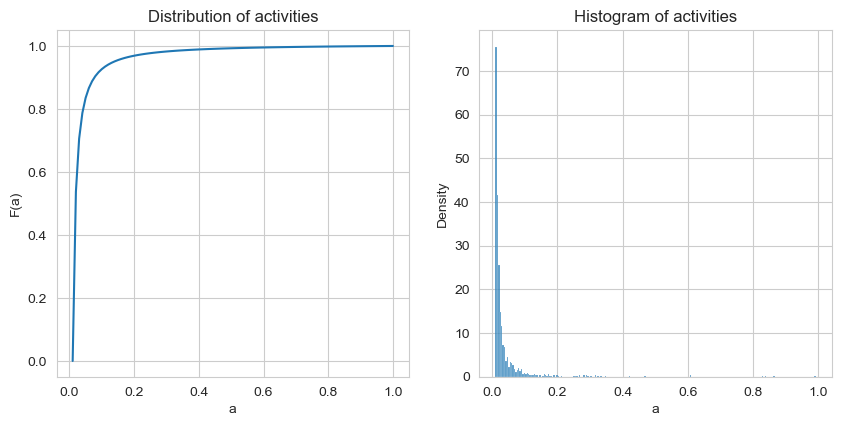

In [5]:
xs = np.linspace(eps, 1, 100)
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

ax[0].plot(xs, F(xs))
ax[0].set_xlabel("a")
ax[0].set_ylabel("F(a)")
ax[0].set_title("Distribution of activities")

sns.histplot(generate_activities(1000), ax=ax[1], stat="density")
ax[1].set_xlabel("a")
ax[1].set_ylabel("Density")
ax[1].set_title("Histogram of activities")
plt.show()

In [6]:
def simulation(N, T, n, K, alpha, beta, r, m=10, delta=0):
    """
    N: number of agents
    T: Time horizon
    n: number of time steps
    K, alpha, beta, r, m: parameters of the model
    """
    if isinstance(m, int): 
        m = [m for i in range(N)]
    
    dt = T / n
    opinions = np.zeros((N, n))
    opinions[:, 0] = np.random.uniform(-1, 1, N) + delta
    activities = generate_activities(N) 
    m = np.sort(m) 
    activities = np.sort(activities) 
    for index in range(n-1):
        agents = opinions[:, index]
        active = np.random.rand(N) < activities
        A = np.zeros((N, N))
        for active_agent in np.where(active)[0]:
            if beta == 0:
                influenced_agents = np.random.choice(np.arange(N), m[active_agent], replace=False)
            else:
                divergence_of_opinion = np.abs(agents[np.arange(N) != active_agent] - agents[active_agent]) ** (-beta)
                contact_probabilities = divergence_of_opinion / np.sum(divergence_of_opinion)
                influenced_agents = np.random.choice(np.arange(N)[np.arange(N) != active_agent], m[active_agent], replace=False, p=contact_probabilities)
            for influenced_agent in influenced_agents:
                A[influenced_agent, active_agent] = 1
                r = 1/m[active_agent] 
                if np.random.rand() < r:
                    A[active_agent, influenced_agent] = 1
                    
        # Runge-Kutta algorithm
        k1 = -agents + K * (A @ np.tanh(alpha * agents))
        k2 = -agents + K * (A @ np.tanh(alpha * (agents + dt * k1 / 2)))
        k3 = -agents + K * (A @ np.tanh(alpha * (agents + dt * k2 / 2)))
        k4 = -agents + K * (A @ np.tanh(alpha * (agents + dt * k3)))
        opinions[:, index + 1] = agents + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6 
    return opinions

## Model Analysis

In [7]:
def plot_curves(curve_matrix, m, black_lines=3):
    fig, ax = plt.subplots()
    curves_for_biggest_ms = curve_matrix[np.argsort(m)[-black_lines:]]
    for curve in curve_matrix:
        below_zero = np.ma.masked_where(curve >= 0, curve)
        above_zero = np.ma.masked_where(curve < 0, curve)
        ax.plot(below_zero, color="red", lw=0.3)
        ax.plot(above_zero, color="blue", lw=0.3)
    for curve in curves_for_biggest_ms:
        ax.plot(curve, color="black")
    return fig 

### Different $m$'s

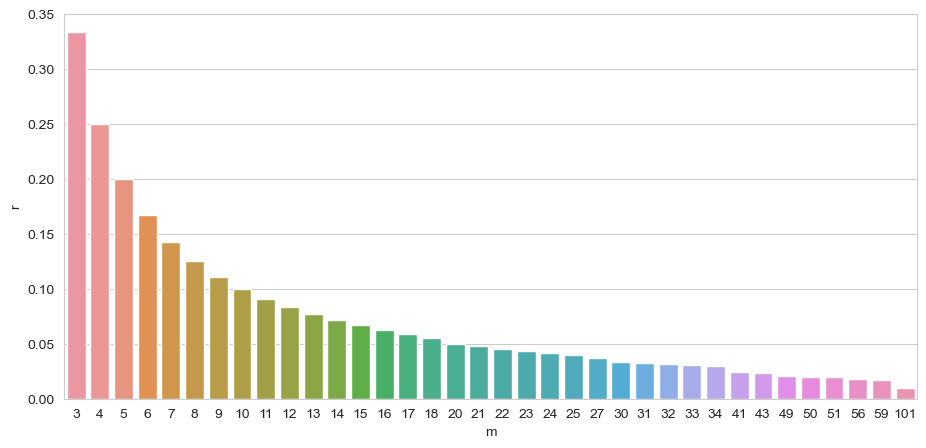

In [8]:
N = 1000
G = nx.barabasi_albert_graph(N, 3)
ms = np.array(list(dict(G.degree()).values()))

fig, ax = plt.subplots(figsize=(11, 5))
sns.barplot(x=ms, y=1/ms)
ax.set_xlabel("m")
ax.set_ylabel("r")
plt.show()

## Simulations of the model for different values of $\alpha$ and $\beta$

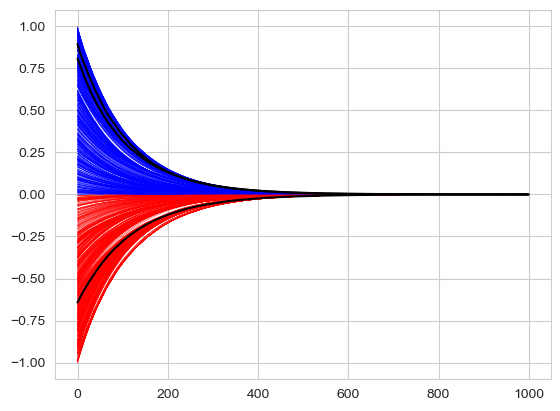

In [9]:
plot_curves(simulation(N, 10, 1000, 3, 0.05, 2, 0.5, m=ms), m=ms)
plt.show()

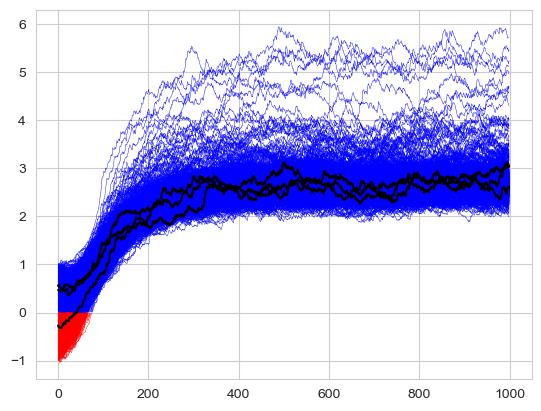

In [10]:
plot_curves(simulation(N, 10, 1000, 3, 3, 0, r=0.5, m=ms), m=ms)
plt.show()

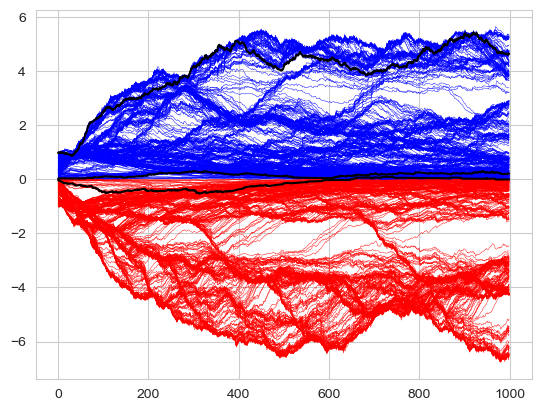

In [11]:
plot_curves(simulation(N, 10, 1000, 3, 3, 3, 0.5, m=ms), m=ms)
plt.show()

## Impact of delta

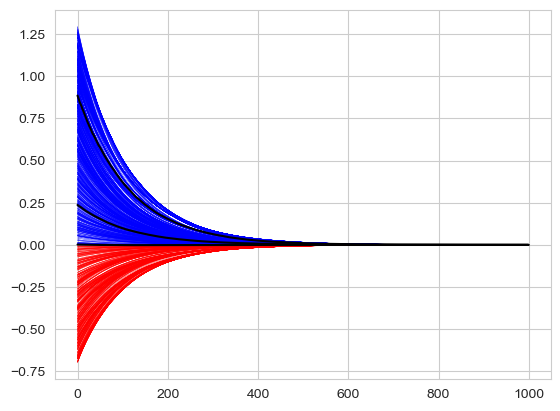

In [12]:
plot_curves(simulation(N, 10, 1000, 3, 0.05, 2, 0.5, delta=0.3, m=ms), m=ms)
plt.show()

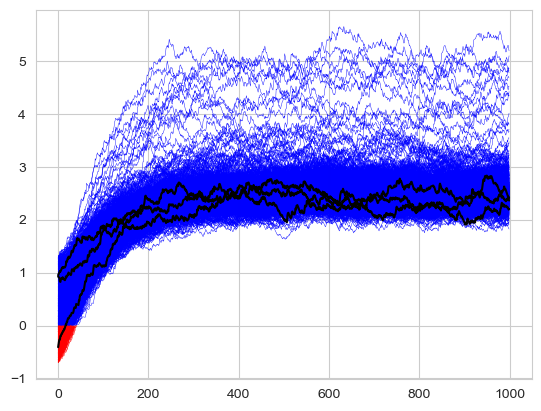

In [13]:
plot_curves(simulation(N, 10, 1000, 3, 3, 0, 0.5, delta=0.3, m=ms), m=ms)
plt.show()

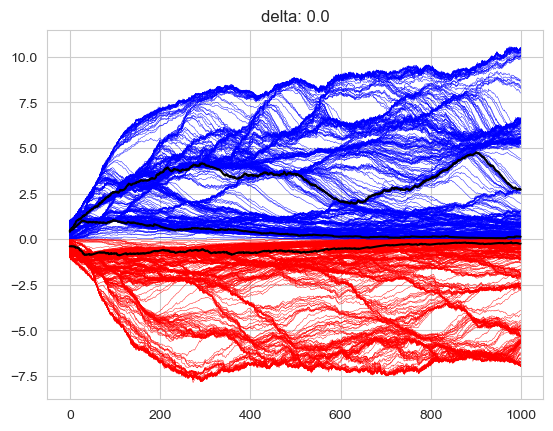

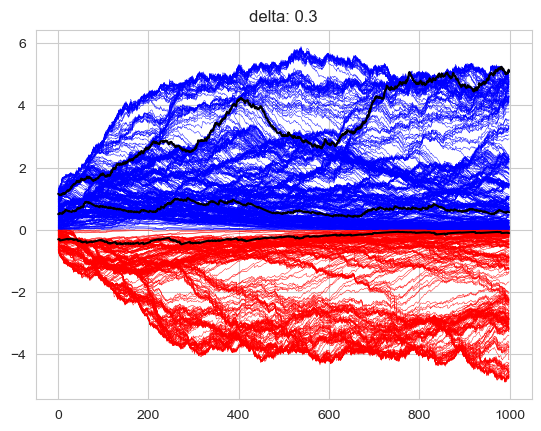

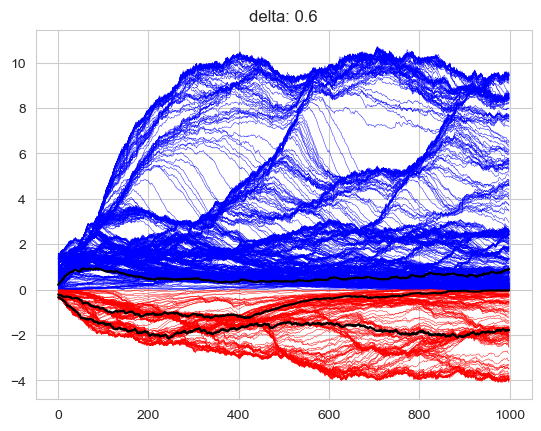

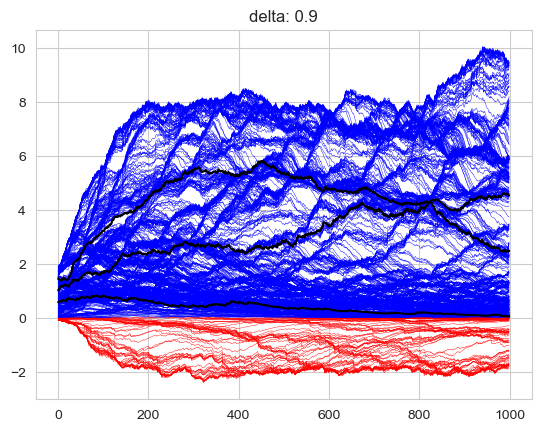

In [14]:
deltas = [0., 0.3, 0.6, 0.9]

for index, delta in enumerate(deltas):
    plot_curves(simulation(N, 10, 1000, 3, 3, 3, 0.5, delta=delta, m=ms), m=ms)
    plt.title(f"delta: {delta}")
    plt.show()

## Transition from consensus to radicalization dynamics

In [64]:
# n = 50
# N = 20
# G = nx.barabasi_albert_graph(N, 3)
# ms = list(dict(G.degree()).values())

# alphas = np.linspace(0, 4, n)
# Ks = np.linspace(0, 4, n)
# all_Ks, all_alphas = zip(*itertools.product(Ks, alphas))

# def f(K, alpha): 
#     return np.abs(np.mean(simulation(N, 10, 1000, K, alpha, 0.5, 0.5, m=ms)[:, -1]))

# cli = Client()
# dview = cli[:]
# dview.execute('import numpy as np')
# dview.push({'N': N, 'ms': ms, 'eps': eps, 'gamma_2': gamma_2, 'generate_activities': generate_activities, 'simulation': simulation}) 
# results = dview.map_sync(f, all_Ks, all_alphas)
# mean_xf = np.array(results).reshape((n, n))

C:\Users\Marcin\AppData\Local\Temp/ipykernel_18476/134570899.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(alphas, Ks, mean_xf, cmap='viridis', vmin=0, vmax=np.max(mean_xf))


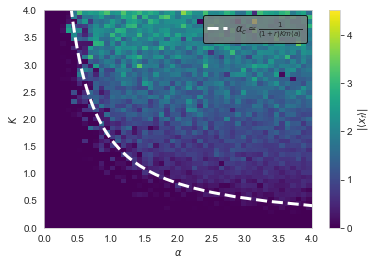

In [66]:
# fig, ax = plt.subplots()

# c = ax.pcolormesh(alphas, Ks, mean_xf, cmap='viridis', vmin=0, vmax=np.max(mean_xf))
# colorbar = fig.colorbar(c, ax=ax)
# ax.plot(1 / ((1 + 0.5) * Ks[1:] * 10 * (1 - gamma) * (1 - eps ** (2 - gamma)) / ((2 - gamma) * (1 - eps ** (1 - gamma)))), Ks[1:], 
#         'w--', linewidth=3, 
#         label = r'$\alpha_c\simeq\frac{1}{(1+r)Km\langle a\rangle}$')

# ax.set_xlabel(r'$\alpha$')
# ax.set_ylabel(r'$K$')
# ax.set_xlim(0, 4)
# ax.set_ylim(0, 4)
# colorbar.ax.set_ylabel(r'$|\langle x_f\rangle|$')
# ax.legend(facecolor='grey', edgecolor='black')

# plt.show()